In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
from fancyimpute import KNN
from sklearn.preprocessing import MinMaxScaler, Normalizer

/Users/rgerkin/miniconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


### Load Snitz Dataset #1

In [2]:
df1 = pd.read_csv('data/snitz/experiment1_comparisons.csv',
            header=0,index_col=0,names=['A','B','Similarity'])
df1_cids = pd.read_csv('data/snitz/experiment1_cids.csv', index_col=0)
df1_cids = df1_cids.applymap(lambda x:x.replace('[','').replace(']','').strip().replace(' ',','))
df1_cids
df1.loc[:, ['A','B']] = df1.loc[:, ['A','B']].applymap(lambda x:df1_cids.loc[x]['Mixture Cids'])
df1.head()

,A,B,Similarity
1,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","240,93009,323,8148,7762,3314,460,6184,798,6054",39.583333
2,"6501,264,2879,7685,7731,326,7888,61138,8030,1183",7710,34.895833
3,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","31276,93009,11002,323,7966,8148,7632,22201,193...",47.395833
4,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","10890,93009,11002,6982,323,8797,7966,8148,7632...",49.479167
5,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","7710,31276,10890,240,93009,11002,6982,323,8797...",58.854167


In [3]:
df1.shape[0],len(set(df1[['A','B']].values.ravel()))

(191, 49)

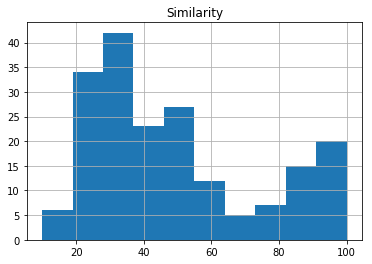

In [4]:
df1.hist('Similarity');

### Load Snitz Dataset #2

In [5]:
df2 = pd.read_csv('data/snitz/experiment2_comparisons.csv',
            header=0,index_col=0,names=['A','B','Similarity'])
df2_cids = pd.read_csv('data/snitz/experiment2_cids.csv', index_col=0)
df2_cids = df2_cids.applymap(lambda x:x.replace('[','').replace(']','').strip().replace(' ',','))
df2_cids
df2.loc[:, ['A','B']] = df2.loc[:, ['A','B']].applymap(lambda x:df2_cids.loc[x]['Mixture Cids'])
df2.head()

,A,B,Similarity
1,"326,26331,6544,1140","7710,62433,7519,7685,3314",42.892077
2,"326,26331,6544,1140","31276,62433,7519,8129,12178,18827,10722",38.292519
3,"326,26331,6544,1140","62433,8797,2758,3314,8635,61138,6054,6544,10722",58.220544
4,"7410,240,93009,8635","7519,8148,31252,8103,5281168,6544",29.732108
5,"7410,240,93009,8635","240,307,7731,2758,12178,62336,8635",62.231981


In [6]:
df2.shape[0],len(set(df2[['A','B']].values.ravel()))

(95, 14)

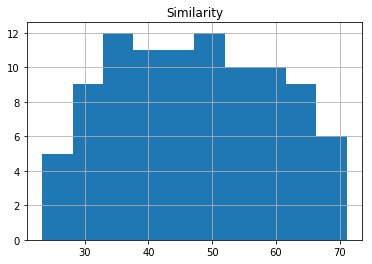

In [7]:
df2.hist('Similarity');

### Load Snitz Dataset #3

In [8]:
df3 = pd.read_csv('data/snitz/experiment3_comparisons.csv',
            header=0,index_col=0,names=['A','B','Similarity'])
df3.head()

,A,B,Similarity
1,7410,19310,14.683684
2,7710,7749,30.498500
3,31276,3314,42.093500
4,7519,8129,48.214500
5,240,8103,59.620500


In [9]:
df3.shape[0],len(set(df3[['A','B']].values.ravel()))

(74, 49)

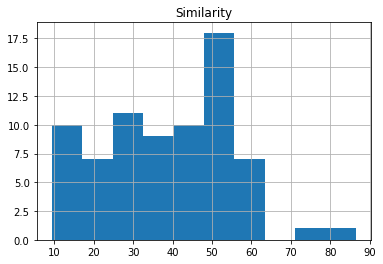

In [10]:
df3.hist('Similarity');

### Get all Snitz CIDs

In [13]:
snitz_cids = []
for x in df1_cids['Mixture Cids']:
    snitz_cids += x.split(',')
for x in df2_cids['Mixture Cids']:
    snitz_cids += x.split(',')
for x in df3[['A','B']].values.ravel():
    snitz_cids += [x]
snitz_cids = np.array(snitz_cids).astype(int)
snitz_cids = set(snitz_cids)
print("There are %d distinct CIDs across all of the Snitz datasets" % len(snitz_cids))

There are 86 distinct CIDs across all of the Snitz datasets


### Load the Dragon data and scale each features to 0-1.

In [16]:
df_dragon = pd.read_csv('data/cids-smiles-dragon.txt').set_index('CID')
df_dragon = df_dragon.iloc[:, 1:] # Remove SMILES column

# Normalize every feature to [0, 1]
mms = MinMaxScaler()
df_dragon[:] = mms.fit_transform(df_dragon)
import pickle
with open('data/dragon-minmaxscaler.pickle', 'wb') as f:
    pickle.dump(mms, f)

/Users/rgerkin/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


### Cleanup and Impute

In [18]:
# No dragon info yet for these CIDs
no_dragon = snitz_cids.difference(df_dragon.index)
no_dragon

{6259976}

In [19]:
# Remove these from the Snitz data
df_snitz_dragon = df_dragon.loc[snitz_cids.difference(no_dragon)]

for nd in no_dragon:
    df_snitz_dragon.loc[nd, :] = 0

In [20]:
# Remove bad features (too many NaNs) and impute remaining NaNs
frac_bad = df_snitz_dragon.isnull().mean()
good = frac_bad[frac_bad<0.3].index
df_snitz_dragon = df_snitz_dragon.loc[:, good]

knn = KNN(k=5)
df_snitz_dragon[:] = knn.fit_transform(df_snitz_dragon.values)

Imputing row 1/86 with 2 missing, elapsed time: 0.146


In [388]:
#from olfactometer.odorants import from_cids
#pubchem_data = from_cids([int(x) for x in snitz_cids])
#pd.DataFrame.from_dict(pubchem_data).set_index('CID').to_csv('data/snitz-odorant-info.csv')

In [396]:
#df_snitz_mordred = pd.read_csv('data/snitz-mordred.csv').set_index('CID')
#df_snitz_mordred[:] = mms.fit_transform(df_snitz_mordred.values)
#df_snitz_mordred.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
CID,,,,,,,,,,,,,,,,,,,,,
5634,0.469768,0.476641,0.5,0.0,0.543198,0.279119,0.305004,0.543198,0.539186,0.648575,...,0.434828,0.350316,0.574890,0.141495,0.584483,0.256410,0.346939,0.263566,0.605317,0.806452
7685,0.540562,0.557665,0.0,0.0,0.563356,0.568673,0.621411,0.563356,0.613871,0.695151,...,0.678160,0.410966,0.540176,0.290074,0.436207,0.384615,0.469388,0.410853,0.654397,0.655914
31252,0.243630,0.235215,0.0,0.0,0.245781,0.487420,0.532623,0.245781,0.703555,0.386513,...,0.541845,0.234485,0.138152,0.313182,0.081034,0.179487,0.224490,0.201550,0.290389,0.225806
5283349,0.339207,0.357763,0.0,0.0,0.425776,0.222327,0.242945,0.425776,0.593768,0.532529,...,0.336217,0.269286,0.391037,0.149374,0.353448,0.205128,0.244898,0.186047,0.441718,0.677419
7710,0.404488,0.439973,0.0,0.0,0.443987,0.562405,0.484675,0.443987,0.673506,0.584364,...,0.561930,0.639575,0.413971,0.171010,0.286207,0.230769,0.346939,0.302326,0.400818,0.548387


In [21]:
df_snitz_features = df_snitz_dragon

In [22]:
# Normalize every molecule to have unit norm (to be unit vector in feature space)
nmr = Normalizer()
df_snitz_features[:] = nmr.fit_transform(df_snitz_features)

In [49]:
def get_unit_distance(row):
    """Convert feature vectors to unit vectors, summing across odorants if needed
    and then getting the vector difference, which will be related to the cosine of
    of the angle between them"""
    a, b, similarity = row
    if isinstance(a, str):
        a = [int(x) for x in a.split(',')]
        b = [int(x) for x in b.split(',')]
    A = df_snitz_features.loc[a,:].values
    B = df_snitz_features.loc[b,:].values
    if A.ndim > 1:
        A = A.sum(axis=0)
        B = B.sum(axis=0)
        A /= np.linalg.norm(A)
        B /= np.linalg.norm(B)
    return pd.Series(np.abs(A - B), index=df_snitz_features.columns, name=row.name)

In [50]:
df_distance = pd.concat([df1, df2, df3]).reset_index(drop=True)
features = list(df_snitz_features.columns)
unit_distances = df_distance.apply(get_unit_distance, axis=1)
df_distance = df_distance.join(df_distance.apply(get_unit_distance, axis=1))
df_distance.loc[:, 'Similarity'] /= 100
df_distance.head()

,A,B,Similarity,MW,AMW,Sv,Se,Sp,Si,Mv,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","240,93009,323,8148,7762,3314,460,6184,798,6054",0.395833,0.000088,0.000161,0.000185,0.000245,0.000258,0.000319,0.000230,...,0.0,0.0,0.004491,0.0,0.004700,0.0,0.000021,0.0,0.009609,0.0
1,"6501,264,2879,7685,7731,326,7888,61138,8030,1183",7710,0.348958,0.000657,0.000543,0.001239,0.001818,0.001513,0.002032,0.002901,...,0.0,0.0,0.004491,0.0,0.014068,0.0,0.004491,0.0,0.018978,0.0
2,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","31276,93009,11002,323,7966,8148,7632,22201,193...",0.473958,0.000125,0.000206,0.000402,0.000704,0.000658,0.000855,0.001290,...,0.0,0.0,0.004491,0.0,0.006939,0.0,0.002223,0.0,0.006962,0.0
3,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","10890,93009,11002,6982,323,8797,7966,8148,7632...",0.494792,0.000137,0.000243,0.000480,0.000749,0.000733,0.000904,0.001223,...,0.0,0.0,0.003091,0.0,0.007721,0.0,0.001611,0.0,0.006315,0.0
4,"6501,264,2879,7685,7731,326,7888,61138,8030,1183","7710,31276,10890,240,93009,11002,6982,323,8797...",0.588542,0.000096,0.000250,0.000435,0.000697,0.000674,0.000849,0.001206,...,0.0,0.0,0.002319,0.0,0.008189,0.0,0.001204,0.0,0.007154,0.0


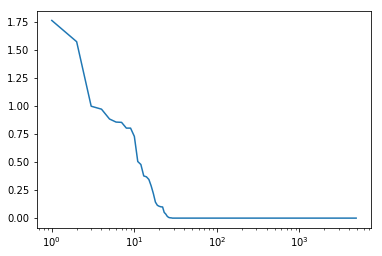

In [401]:
%matplotlib inline
from sklearn.linear_model import Lasso
model = Lasso(alpha=1e-4, max_iter=1e5)
X = df_distance[features]
y = df_distance['Similarity']
model.fit(X, y)
import matplotlib.pyplot as plt
plt.plot(1+np.arange(len(model.coef_)),sorted(np.abs(model.coef_))[::-1]);
plt.xscale('log')

In [374]:
from sklearn.model_selection import cross_validate, ShuffleSplit

def r_score(model, X, y_true):
    y_pred = model.predict(X)
    #print(y_true.shape, y_pred.shape)
    return np.corrcoef(y_true, y_pred)[0,1]

alphas = np.logspace(-5, -2, 9)
n_splits = 25
cv = ShuffleSplit(n_splits=n_splits, test_size=0.2)
training = np.zeros((len(alphas), n_splits))
testing = np.zeros((len(alphas), n_splits))

for i, alpha in enumerate(alphas):
    print(alpha)
    model = Lasso(alpha=alpha, max_iter=1e5)
    fff = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=r_score)
    training[i, :] = fff['train_score']
    testing[i, :] = fff['test_score']

1e-05
2.3713737056616554e-05
5.623413251903491e-05
0.0001333521432163324
0.00031622776601683794
0.0007498942093324559


/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :

0.0017782794100389228


/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :

0.004216965034285823


/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :

0.01


/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rgerkin/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :

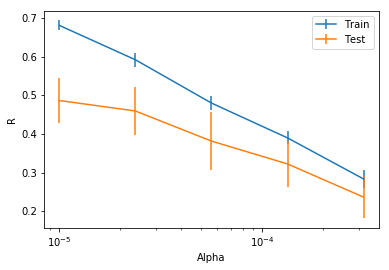

In [375]:
plt.errorbar(alphas, training.mean(axis=1), yerr=training.std(axis=1), label='Train')
plt.errorbar(alphas, testing.mean(axis=1), yerr=testing.std(axis=1), label='Test')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R')
plt.legend()

In [402]:
model = Lasso(alpha=1e-4, max_iter=1e5)
model.fit(X, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=100000.0,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [406]:
snitz_space_weights = pd.Series(model.coef_, index=features, name='Weight')
snitz_space_weights = snitz_space_weights[np.abs(snitz_space_weights)>1e-5]
snitz_space_weights

NNRS           -0.477513
SM03_EA(dm)    -0.368146
Eig09_EA(bo)   -0.050650
Eig07_EA(dm)   -0.504431
Eig11_EA(ri)   -0.802003
G3s            -0.344271
E2s            -0.855908
HATS4v         -0.142621
HATS4e         -0.105318
nR=Cp          -0.218425
nRCHO          -0.997088
C-008          -0.970852
C-015          -0.114213
C-036          -0.006317
O-060          -0.036627
NdCH2          -0.002980
CATS2D_05_DL   -0.100818
CATS2D_01_NL   -1.572119
B01[C-N]       -1.761445
B01[C-S]       -0.801880
B02[C-N]       -0.099297
B02[C-S]       -0.016563
B03[C-N]       -0.002051
B03[C-S]       -0.883230
B05[C-C]       -0.286078
B06[C-C]       -0.853228
B07[C-O]       -0.728351
B08[C-O]       -0.375706
Name: Weight, dtype: float64

In [408]:
snitz_space_weights.to_csv('data/snitz_dragon_weights.csv', header=True)